In [2]:
!pip install matplotlib


In [18]:
import numpy as np

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

2021-09-04 15:19:37.855394: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-04 15:19:41.165235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46729 MB memory:  -> device: 0, name: RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2021-09-04 15:19:41.166875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46729 MB memory:  -> device: 1, name: RTX A6000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2021-09-04 15:19:41.168388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Running on multiple GPUs  ['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']
Number of accelerators:  4


In [5]:
ds = tfds.load('davis', split='train', shuffle_files=True, try_gcs=True, data_dir="/playpen/tgreer/tfds")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60 [00:00<?, ? examples/s]

Shuffling davis-train.tfrecord...:   0%|          | 0/60 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/30 [00:00<?, ? examples/s]

Shuffling davis-validation.tfrecord...:   0%|          | 0/30 [00:00<?, ? examples/s]

Dataset davis downloaded and prepared to /playpen/tgreer/tfds/davis/480p/2.1.0. Subsequent calls will reuse this data.


In [85]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

LEARNING_RATE = 0.0001
LEARNING_RATE_EXP_DECAY = 1# = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.

SCALE = 1
SIDE_LENGTH = 90
def videoToPairDataset(video):
  video = video["video"]["frames"]
  frame_stride = 5
  inner_ds_A = tf.data.Dataset.from_tensor_slices(video[0:-frame_stride:frame_stride, ::4, :480:4])
  inner_ds_B = tf.data.Dataset.from_tensor_slices(video[frame_stride::frame_stride, ::4, :480:4])
  inner_ds = tf.data.Dataset.zip((inner_ds_A, inner_ds_B))
  return inner_ds
ds_f = ds.interleave(videoToPairDataset, cycle_length=10, num_parallel_calls=10)
df_f = ds_f.cache()
ds_f = ds_f.shuffle(buffer_size=800)
ds_f = ds_f.repeat()
ds_f = ds_f.batch(BATCH_SIZE, drop_remainder=True)
ds_f = ds_f.map(lambda x, y: ((x, y),x))
ds_f = ds_f.prefetch(-1)




In [86]:
q = iter(ds_f)


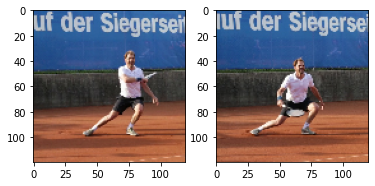

In [87]:
import matplotlib.pyplot as plt
a = next(q)
plt.subplot(1, 2, 1)
plt.imshow(a[0][0][0])
plt.subplot(1, 2, 2)
plt.imshow(a[0][1][0])

In [9]:
def make_model():
    model = tf.keras.Sequential(
      [
        
        #tf.keras.layers.ZeroPadding2D(padding=(15, 15), input_shape=(SIDE_LENGTH, SIDE_LENGTH, 1)),
        
        tf.keras.layers.Conv2D(filters=64, kernel_size=11, padding='valid', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=64, kernel_size=11, padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=64, kernel_size=11, padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
       
        tf.keras.layers.Conv2D(filters=512, kernel_size=1, padding='valid', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm
       
        tf.keras.layers.Conv2D(filters=64, kernel_size=1, padding='valid', use_bias=False), # no bias necessary before batch norm
        #tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        #tf.keras.layers.Activation('relu'), # activation after batch norm
      ])
    
    input_A = tf.keras.Input(shape=(SIDE_LENGTH + 30, SIDE_LENGTH + 30, 3))
    input_B = tf.keras.Input(shape=(SIDE_LENGTH + 30, SIDE_LENGTH + 30, 3))
    features_A = model(input_A)
    features_B = model(input_B)

    features_A = tf.keras.layers.Reshape(target_shape=(SIDE_LENGTH * SIDE_LENGTH, 64))(features_A)
    features_B = tf.keras.layers.Reshape(target_shape=(SIDE_LENGTH * SIDE_LENGTH, 64))(features_B)

    cc = tf.keras.layers.Lambda(lambda var: tf.linalg.matmul(var[0], var[1], transpose_b=True), name="matmul")([features_A, features_B])

    cc_A = tf.keras.layers.Softmax(axis=-1)(cc)
    cc_B = tf.keras.layers.Softmax(axis=-2)(cc)

    loss = tf.keras.layers.Multiply()([cc_A, cc_B])

    loss = tf.keras.layers.Lambda(lambda var: tf.clip_by_value(var, 0, .3), name="clip")(loss)

    def fmapICON_clamp_loss(tensor, nonsense):
    
      return -tf.math.reduce_sum(nonsense) / BATCH_SIZE / SIDE_LENGTH / SIDE_LENGTH * strategy.num_replicas_in_sync

    outer_model = tf.keras.Model(inputs=(input_A, input_B), outputs=loss)

    outer_model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss=fmapICON_clamp_loss)
    return outer_model
    
with strategy.scope():
    model = make_model()
# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 90, 90, 64)   1082112     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 8100, 64)     0           sequential[0][0]             

In [88]:
EPOCHS = 60
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)
  
history = model.fit(ds_f,
                    steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    callbacks=[lr_decay])

final_stats = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", final_stats[1])

Steps per epoch:  937


2021-09-04 16:54:18.119498: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "ParallelInterleaveDatasetV4/_29"
op: "ParallelInterleaveDatasetV4"
input: "OptionsDataset/_23"
input: "Const/_24"
input: "Const/_25"
input: "Const/_26"
input: "Const/_27"
input: "Const/_24"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "deterministic"
  value {
    s: "default"
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_interleave_videoToPairDataset_31449"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: 3
        }
      }
      shape {
        dim {
          size: -1
        }
        

Epoch 1/60

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
658/937 [====================>.........] - ETA: 2:09 - loss: -0.2009

KeyboardInterrupt: 

In [89]:
(A, B), Q = next(iter(ds_f))

In [90]:
x = model((A[:3], B[:3]))

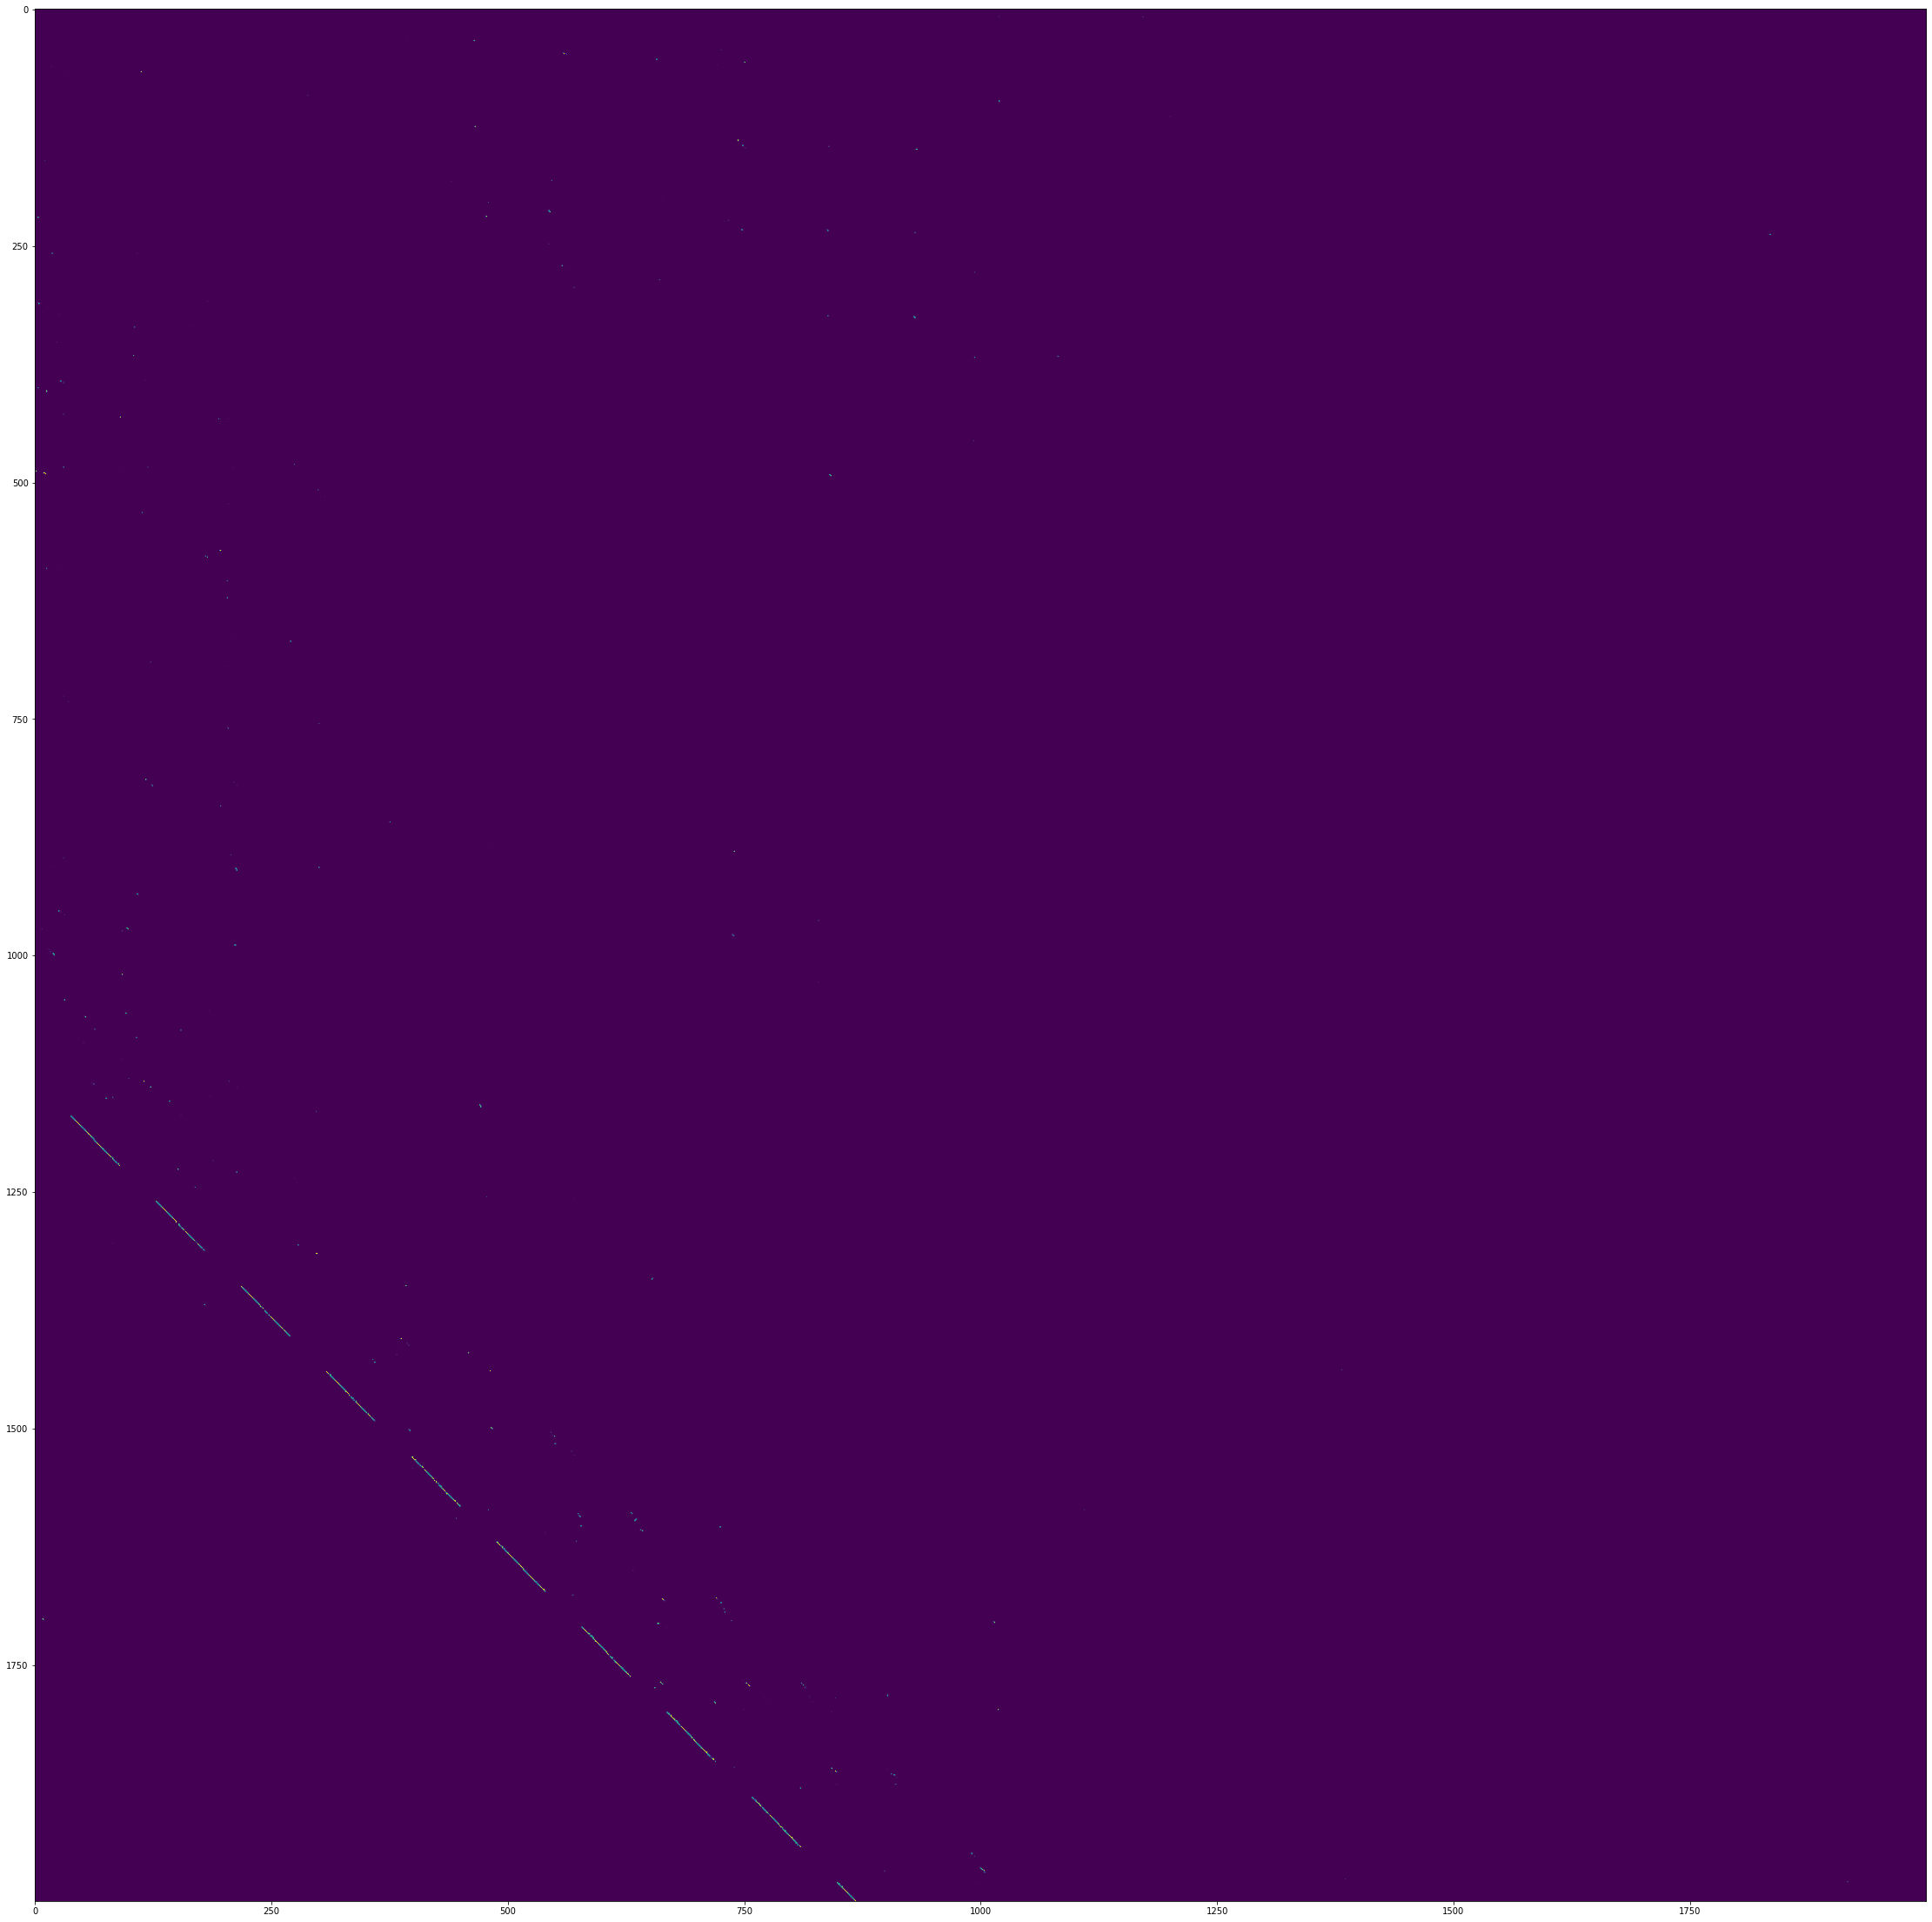

In [91]:
plt.figure(figsize=(40, 40))
plt.imshow(x[2, :2000, :2000])

In [92]:
inner_model = model.layers[2]

In [93]:
F_A = tf.reshape(inner_model(A)[:10], (10, SIDE_LENGTH ** 2, 64))
F_B = tf.reshape(inner_model(B)[:10], (10, SIDE_LENGTH ** 2, 64))
cc = tf.linalg.matmul(F_A, F_B, transpose_b=True)
cc = tf.nn.softmax(cc, axis=-1)
cc = tf.reshape(cc, [10] + [SIDE_LENGTH] * 4)
cc = np.array(cc)

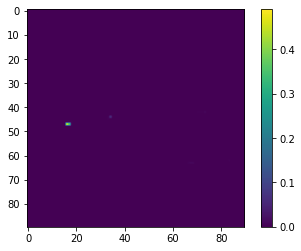

In [94]:
plt.imshow(cc[0, 46, 19])
plt.colorbar()

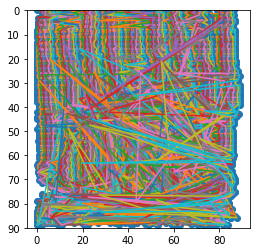

In [95]:
plt.figure(figsize=(4, 4))
import scipy.ndimage
grid = np.array(
  [
    [
        [
            scipy.ndimage.measurements.center_of_mass(cc[k, i, j].transpose())
            for i in range(SIDE_LENGTH)
        ]
        for j in range(SIDE_LENGTH)
    ]
   for k in range(10)]
)
#grid[:, :, 0] = scipy.ndimage.gaussian_filter(grid[:, :, 0], 1)
#grid[:, :, 1] = scipy.ndimage.gaussian_filter(grid[:, :, 1], 1)

#grid = grid[3:-3, 3:-3]

plt.plot(grid[0, :, :, 0], grid[0, :, :, 1])
plt.plot(grid[0, :, :, 0].transpose(), grid[0, :, :, 1].transpose())
plt.ylim(SIDE_LENGTH, 0)

plt.scatter(grid[0, :, :, 0], grid[0, :, :, 1])

plt.ylim(SIDE_LENGTH, 0)
plt.show()

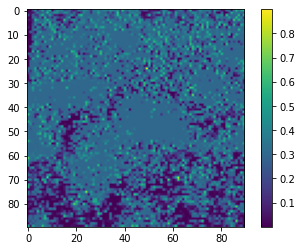

In [96]:
plt.imshow(tf.reshape(tf.reduce_sum(x, axis=-1)[0], (SIDE_LENGTH, SIDE_LENGTH)))
plt.colorbar()

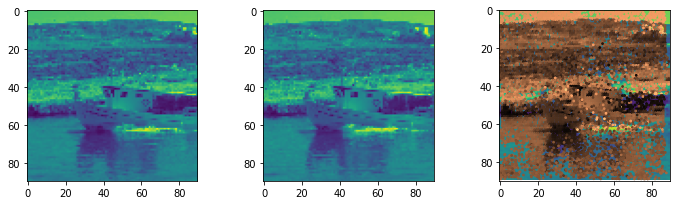

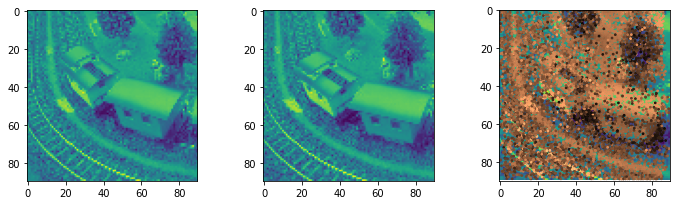

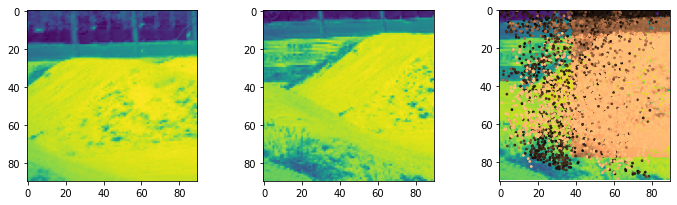

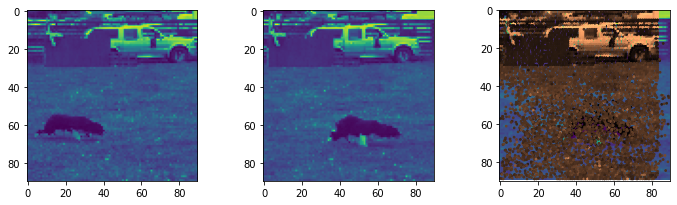

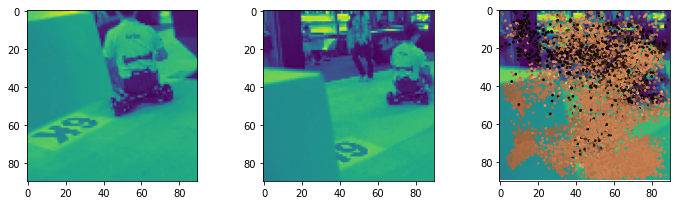

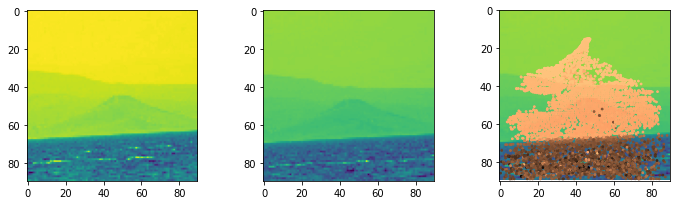

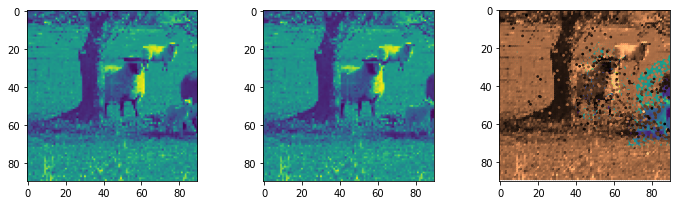

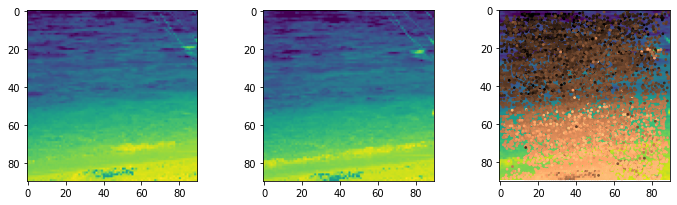

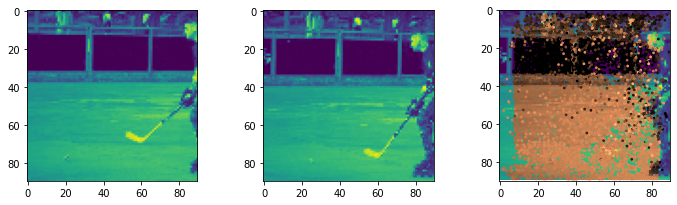

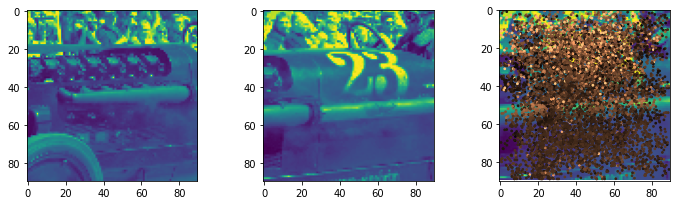

In [97]:
for k in range(10):
  plt.figure(figsize=(12, 37))
  plt.subplot(10, 3, 1)
  plt.imshow(A[k, 15:-15, 15:-15, 0])
  plt.subplot(10, 3, 2)
  plt.imshow(B[k, 15:-15, 15:-15, 0])
  plt.subplot(10, 3, 3)
  plt.ylim(SIDE_LENGTH, 0)
  plt.imshow(B[k, 15:-15, 15:-15, 0])
  plt.scatter(grid[k, :, :, 0], grid[k, :, :, 1], c=np.array(A)[k, 15:-15, 15:-15, 0].transpose(), cmap="copper", s=3)

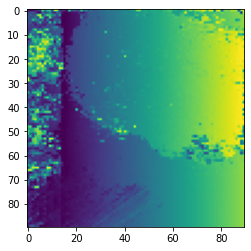

In [74]:
g = grid[9].transpose(1, 0, 2)
plt.imshow(g[:, :, 0])